# Week 11 Homework.

I've provided solutions to both of the homework options. The first one I borrowed, and the second I improvised myself.

## The web-scraping option.

For this part, I have simply copied Bob Morrissey's solution, editing it very lightly.

In [6]:
# First, import needed modules, and borrow some functions from our 
# class notebook.

import requests
from bs4 import BeautifulSoup

import time

def trythreetimes(url):
    ''' Sometimes when you initially attempt to load a page, you get an error:
    a page with status 404 or 503, etc.
    
    There are sophisticated ways to handle that, but let's try a simple way:
    Keep trying until it works. We'll stop after three tries, so as not to hang
    up in an infinite loop.
    '''
    found = False
    tries = 0
    
    while not found and tries < 3:

        if tries > 0:
            time.sleep(1)
            # maybe the web needs a brief rest?
        
        tries += 1
        
        try:
            page = requests.get(url)
            if page.status_code == 200:
                # success!
                found = True
            # otherwise found will stay False
            else:
                print(page.status_code)
            
        except Exception:
            # something really went wrong; let's quit
            tries = 3
            page = ''
    
    # we'll return the found flag so whoever called this
    # function knows whether it worked
    return page, found

def getsearchpage(atitle):
    ''' Takes a title string, breaks it into words, joins the
    words with a plus character, and pours it into a url of the
    correct form for IMDb. Then triesthreetimes.
    '''
    
    words = atitle.split()
    url = "http://www.imdb.com/find?ref_=nv_sr_fn&q=" + '+'.join(words) + '&s=all'
    page, found = trythreetimes(url)
    return page, found

def link2movie(movie_title):
    page, found = getsearchpage(movie_title)
    search_page = requests.get(page.url) 
    soup = BeautifulSoup(page.text, "html.parser")
    html_object = soup.find('td', 'result_text')
    html_object2 = html_object.find('a')
    pagelink = html_object2.get('href')
    ''' Takes a movie title, gets the URL for the
    search page for that movie, and then crawls the
    search page to get the link to the movie page
    itself.
    '''
    return pagelink

Now we define a function that gets the needed elements for each movie. All the code below is from Bob; as he notes, these details are a bit of a pain to work out.

The only thing I added was a line that strips the newline characters from the storyline.


In [7]:

def movie_data(movie_title):
    link = link2movie(movie_title)
    url = 'http://www.imdb.com/' + link
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    try:
        title_html = soup.find('h1', itemprop="name")
        title = title_html.getText()
    except:
        title = None
    try:
        storyline_html = soup.find_all('div', itemprop="description")
        # There are two descriptions; we want storyline, which is the second one
        storyline = storyline_html[1].getText()
        storyline = storyline.strip()
    except:
        storyline = None
    # Budget is not always present; so use try except
    try:
        budget_search = re.compile('Budget')
        budget_html = soup.find('h4', text = budget_search)
        # budget number is in the middle of a set of h4 tags and a span, 
        budget = budget_html.parent.contents[2]
        budget.strip()
    except:
        budget = None
    # Gross is also not always there, so try and except:
    try: 
        gross_search = re.compile('Gross')
        gross_html = soup.find('h4', text = gross_search)
        # gross number is in the same place as the budget number
        gross = gross_html.parent.contents[2]
        gross.strip()
    except:
        gross = None
    # Multiple genres require a list
    try:
        genre_html = soup.find('div', itemprop = 'genre')
        genres = genre_html.find_all('a')
        genre_list = []
        for i in range(len(genres)):
            text = genres[i].getText()
            genre_list.append(text)
    except:
        genre = None
    return title, budget, gross, storyline, genre_list
   
title_list = []
budget_list = []
gross_list = []
storyline_list = []
genre_list_final = []

movies = ['Star Wars', 'Groundhog Day', 'You Can Count On Me', 'The Big Lebowski', 'Spaceballs', 'Jaws']


for movie in movies:
    title, budget, gross, storyline, genre_list = movie_data(movie)
    title_list.append(title)
    budget_list.append(budget)
    gross_list.append(gross)
    storyline_list.append(storyline)
    genre_list_final.append(genre_list)


### Now turn into a df

Now that I have these lists defined by my search, I can turn these into series and then zip them into a data frame.

In [8]:
import pandas as pd
import numpy as np

titles = pd.DataFrame(
    {'title': title_list, 
     'budget': budget_list,
     'gross': gross_list,
     'storyline': storyline_list,
     'genres': genre_list_final
    })

cols = ['title', 'budget', 'gross', 'storyline', 'genres']

titles = titles[cols]
titles



,title,budget,gross,storyline,genres
0,Star Wars: Episode IV - A New Hope (1977),"$11,000,000","$460,935,665","The Imperial Forces, under orders from cruel D...","[ Action, Adventure, Fantasy, Sci-Fi]"
1,Groundhog Day (1993),"$14,600,000","$70,906,973",A weather man is reluctantly sent to cover a s...,"[ Comedy, Fantasy, Romance]"
2,You Can Count on Me (2000),"$1,200,000","$9,180,275",Adult siblings Sammy Prescott and Terry Presco...,[ Drama]
3,The Big Lebowski (1998),"$15,000,000","$17,439,163","When ""The Dude"" Lebowski is mistaken for a mil...","[ Comedy, Crime, Mystery]"
4,Spaceballs (1987),"$22,700,000","$38,119,483",King Roland of the planet Druidia is trying to...,"[ Adventure, Comedy, Sci-Fi]"
5,Jaws (1975),"$8,000,000","$260,000,000","It's a hot summer on Amity Island, a small com...","[ Adventure, Drama, Thriller]"


For our purposes, that's a solution! But, as Bob notes, there are still probably edge cases that will break this code. Unfortunately, real websites don't always follow a consistent format. If you really had to do this you might have to painstakingly explore the edge cases and come up with ad-hoc rules to deal with them.

That's data cleaning for you.

## The option that involved extracting genre counts from a text file.

I hoped this would be less tricky than the web scraping. 

But it turned out to be a bit trickier than I was expecting, because the rows in the file had an UNPREDICTABLE number of tabs between the title and the genre column. The file had been formatted to be easy on the human eye (lining the columns up visually), which made it difficult to read computationally.

However, with a couple of adjustments, it's still possible to extract some interesting data from the file.

And actually, this is a really good example of the sort of messy files you'll encounter in the real world, and the sort of things you'll need to do to clean them up.

In [12]:
import re
from collections import Counter
import pandas as pd

still_intro = True

genrecounters = dict()

with open('/Users/rdubnic2/Documents/lis590dsh/Data/genres_edited.list', encoding ='latin-1') as f:
    for line in f:
        line = line.strip()
        
        # otherwise we end up with a newline character on each genre
        # i.e., "Drama\n"
        
        if still_intro:
            if line.startswith('"!Next?"'):
                still_intro = False
            else:
                continue
        
        # This is a slightly cheesy way to skip the long prose introduction to the file.
        # It's "cheesy" because it relies on knowing how the first line of actual data
        # happens to begin. But what can you do? The authors of the file haven't 
        # appropriately separated their commentary from the table itself.
        
        fields = line.split('\t')
        
        if len(fields) < 2:
            continue
            # If there are fewer than two fields, this line won't have the
            # information we need to count it. So we skip it.
            
        if len(fields[0]) < 1:
            continue
            # The title (the first field) can't be blank. If it is, we skip it.
            
        else:
            
            try:
                match = re.search('\([0-9]{4}\)', fields[0])
                
                if match is not None:
                    # I had to add this if clause, because not every line has a 
                    # well-formed date. Sometimes your re.search will not find anything.
                    
                    matchedstring = match.group(0)
                    ctr += 1
                    stringdate = matchedstring[1:5]
                    intdate = int(stringdate)
                    
                else:
                    intdate = -1
                    
                    
            except Exception:
                # maybe there's no date in this line?
                intdate = -1
                # print(Exception)
                # I don't think we will actually trigger this exception.
            
            if intdate > 1930:
                # this if-clause excludes years before 1930, and also
                # incidentally ignores errors (which will have caused
                # the date to be negative-one).
                
                genre = fields[-1]
                
                # In a well-formed dataset, you would expect genre to be fields[1] --
                # the SECOND column in the data.
                
                # In this dataset, however, there are an UNPREDICTABLE number of tabs
                # separating the title from the genre on each line. So we have to take the
                # last field (whatever number it is) as the genre.
                
                # We can do this by selecting fields[-1].
                
                # This is an example of the kind of problem that people create when they
                # design a file for the human eye. Don't do it at home! Design
                # your spreadsheets consistently, so they can be read by machines.
                
                if len(genre) < 2:
                    # This would be an error. We should not encounter
                    # genres whose name includes only a single letter.
                    # Again, this is probably not necessary. But when
                    # you're dealing with messy data it's a good idea to
                    # anticipate lots of possible edge cases.
                    
                    print("Error: blank or short genre.")
                    continue
                    
                if genre not in genrecounters:
                    genrecounters[genre] = Counter()
                    for i in range(1930, 2015):
                        genrecounters[genre][i] = 0
                
                # When we encounter a new genre, we initialize it to
                # have a zero count in each year. If we don't do this,
                # we'll end up with some NaN values in the final
                # dataframe.
                
                # Then, at last -- having tested for various possible
                # errors and accidents, and surmounted all the obstacles --
                # we finally count this entry and assign it to the right genre
                # and date.
                
                genrecounters[genre][intdate] += 1

genredata = pd.DataFrame(genrecounters)
print(genredata)

Empty DataFrame
Columns: []
Index: []


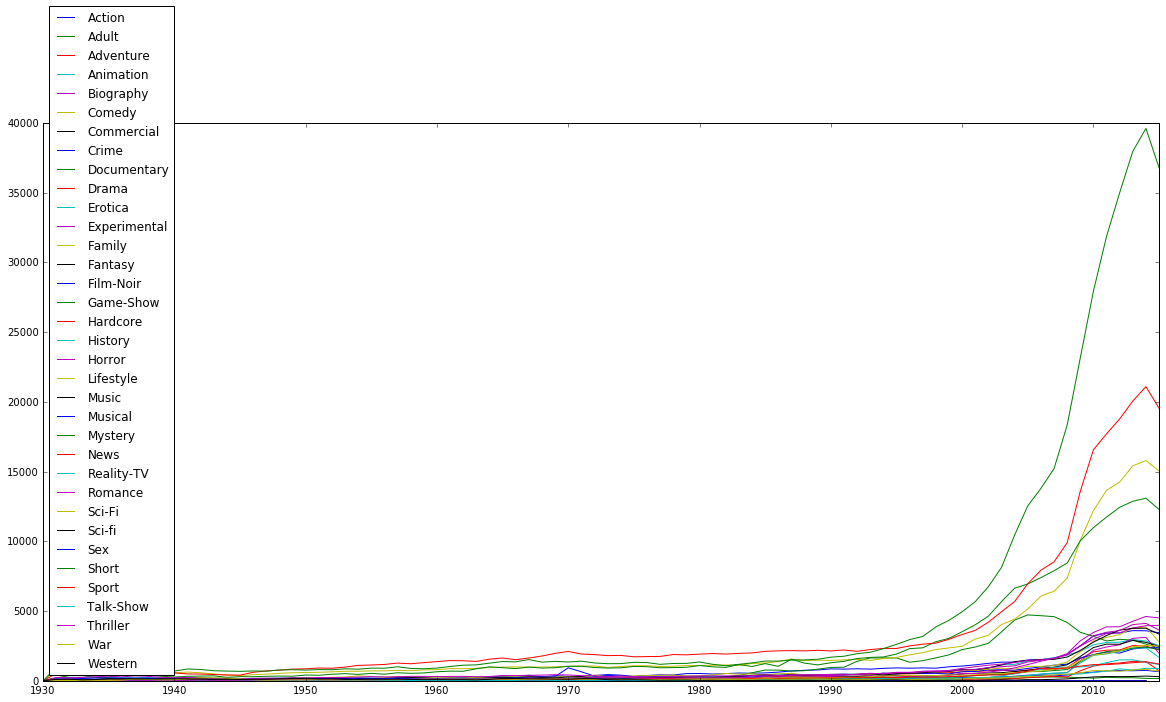

In [101]:
# Let's see what we've got here

import matplotlib.pyplot as plt
%matplotlib inline

# There are a number of ways to increase the figure size.
# This is one.

from matplotlib import rcParams
rcParams['figure.figsize'] = (20.0, 10.0)

genredata = genredata.loc[1930:2015, ]
genredata.plot()

It looks like the huge, dominant trend is simply an increase in the number of films (and television shows, etc) that have IMDb entries. This makes it difficult to see any meaningful pattern in the relative positions of different genres.

To address this, we're going to want to consider the *relative* frequencies of different genres. I.e., in each year, we're going to want to divide the genre count for each genre by the *total* number of entries for that year. This will factor out the massive increase in sheer numbers of entries.



In [102]:
# To create relative frequencies, we're going to need a column that has the total number of 
# IMDb entries for each year. This requires summing across each row.

normalized_data = genredata.copy()

normalized_data['allgenres'] = normalized_data.sum(axis = 1)

# We're also going to want to select some columns to focus on, because there are just too many lines in that graph!
# So let's get a list of the most common genres.
# This requires summing columns (same method as above, with a different "axis.")

columnsums = normalized_data.sum(axis = 0)
columnsums.sort_values(inplace = True, ascending = False)
print(columnsums)

columns_to_include = list(columnsums[2:17].index.values)
columns_to_include.append("allgenres")
normalized_data = normalized_data.loc[ : , columns_to_include]

print()
print('The ones we kept:')
print(normalized_data.columns.values)

allgenres       1871001.0
Short            417643.0
Drama            283151.0
Comedy           207426.0
Documentary      199678.0
Adult             76534.0
Action            60003.0
Romance           59951.0
Thriller          52268.0
Family            51371.0
Music             50634.0
Animation         50485.0
Crime             41834.0
Horror            41567.0
Adventure         37678.0
Fantasy           32958.0
Sci-Fi            28370.0
Mystery           27043.0
Biography         25458.0
History           22187.0
Sport             20714.0
Musical           17471.0
Reality-TV        14696.0
War               14522.0
News              11365.0
Talk-Show         11108.0
Western            8790.0
Game-Show          5365.0
Film-Noir           724.0
Commercial            1.0
Erotica               1.0
Experimental          1.0
Sci-fi                1.0
Hardcore              1.0
Lifestyle             1.0
Sex                   1.0
dtype: float64

The ones we kept:
['Drama' 'Comedy' 'Documentary

Now we need to convert columns into normalized frequencies. This means dividing each column by the values in "allgenres." Pandas will automatically "broadcast" the division across rows, so we don't need to step through row by row for each column. We can divide whole columns by each other, and understand that what is really happening is a division of "this genre" by the "total for all genres" in each year.

In [103]:
for col in normalized_data.columns:
    if col != 'allgenres':
        normalized_data[col] = normalized_data[col] / normalized_data['allgenres']

I'm just going to choose a few interesting genres to plot.

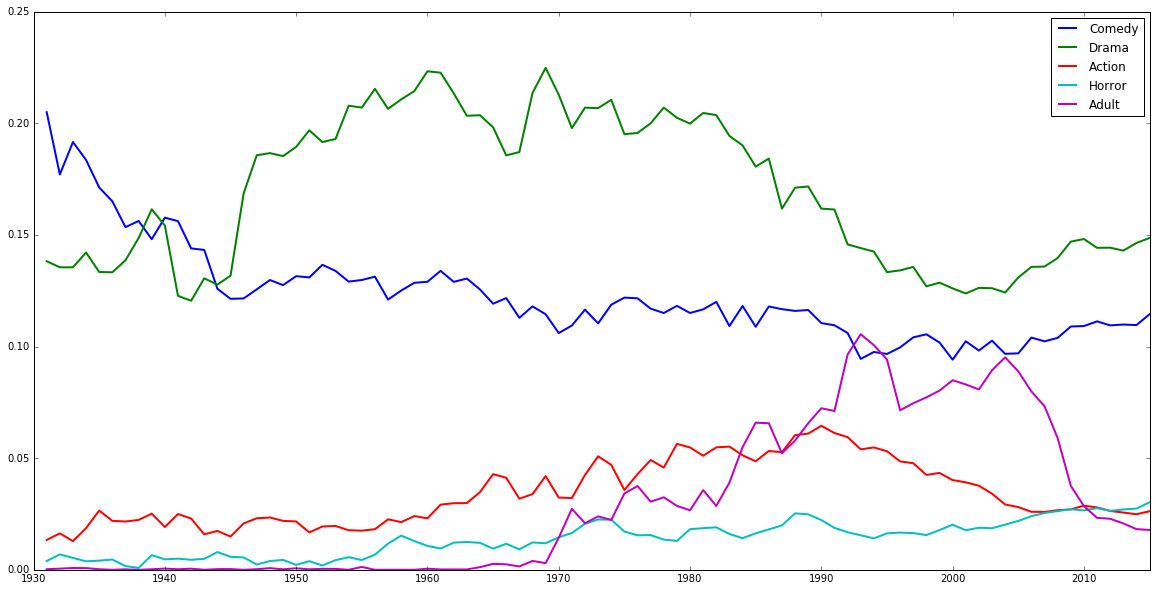

In [104]:
normalized_data.loc[ :, ['Comedy', 'Drama', 'Action', 'Horror', 'Adult']].plot(linewidth = 2)

I'm not sure how meaningful this really is, because I don't think we're looking strictly at movies, for instance.
Instead we're looking at a combination of movies, television shows, and perhaps several other media. So the relative frequencies of some genres might go down just because television gets added to the mix.

But with that caveat, it looks like a few trends are visible here: a long decline of comedy, a peak in the "Action" genre around 1990, and of "Adult" slightly later. "Horror" is a small fraction of the overall mix, but seems to rise steadily.